In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sc
from scipy import stats
from scipy.fftpack import fft
from scipy.stats import iqr
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler,RobustScaler


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,cross_validate,train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE,SMOTENC,SVMSMOTE

dir = '/content/drive/MyDrive/EE576/Project5/dataset'

excel_files = [file for file in os.listdir(dir) if file.endswith('.xlsx')]
excel_files.sort()


# Reading the Excel files and concatenate them

def read(file):
  List = []
  dataLists = []

  for f in file:
    df = pd.read_excel(os.path.join(dir, f))
    df.drop(columns = ['Prey'], axis=1,inplace=True,errors='ignore',index = False)
    df.columns = ['Date_Time', 'ODBA','X_static', 'Y_static', 'Z_static', 'X_dynamic','Y_dynamic', 'Z_dynamic', 'Labels']
    List.append(df)

  dataList = pd.concat(List,ignore_index=True)
  return dataList

# Feeding = [0+4(N-1)]  N = 1,2...6 <-#(7-1)
# NDM = [1+4(N-1)]
# Resting = [2+4(N-1)]
# Swiming = [3+4(N-1)]
x1 = [20,13,22,3] #indices of files list with the least amount of data for testing
index_list = [i for i in range(len(excel_files))]
x2= [i for j, i in enumerate(index_list) if j not in x1]
test = [excel_files[x] for x in x1]
train = [excel_files[x] for x in x2]

data_test = read(test)
data_train = read(train)


In [ ]:
# Show how the files were organized before uploading, useful to choose which
# index to choose for test dataset

#print((excel_files))

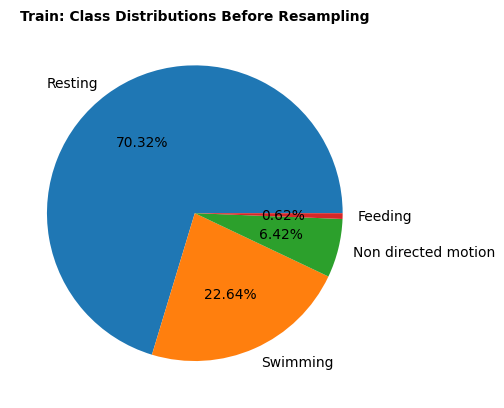

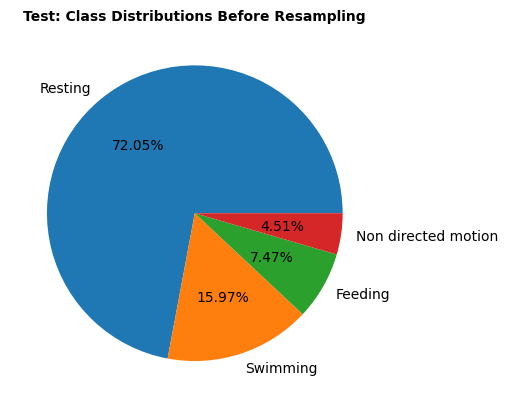

In [ ]:
# Show percentage of the split dataset
classCount = data_train['Labels'].value_counts()
plt.title("Train: Class Distributions Before Resampling", fontsize = 10, weight='bold')
plt.pie(classCount,labels=classCount.index,radius=1, autopct='%.2f%%')
plt.show()

classCount = data_test['Labels'].value_counts()
plt.title("Test: Class Distributions Before Resampling", fontsize = 10, weight='bold')
plt.pie(classCount,labels=classCount.index,radius=1, autopct='%.2f%%')
plt.show()

In [ ]:
print(data_train['Labels'].value_counts())
print(data_test['Labels'].value_counts())

Labels
Resting                1196954
Swimming                385375
Non directed motion     109250
Feeding                  10600
Name: count, dtype: int64
Labels
Resting                27975
Swimming                6200
Feeding                 2900
Non directed motion     1750
Name: count, dtype: int64


In [ ]:
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
data_test["Labels"] = le.fit_transform(data_test['Labels'])
data_train["Labels"] = le.fit_transform(data_train['Labels'])

In [ ]:
data_train['Labels'].value_counts()

Labels
2    1196954
3     385375
1     109250
0      10600
Name: count, dtype: int64

In [ ]:
x_train = data_train.drop(['Date_Time','Labels'], axis=1)
y_train= pd.DataFrame(data_train['Labels'])
x_test = data_test.drop(['Date_Time','Labels'], axis=1)
y_test= pd.DataFrame(data_test['Labels'])

# FEATURE EXTRACTION

In [ ]:
# FEATURE EXTRACTION FOR KNN
TIME_PERIODS= 25
STEP_DISTANCE = 25
N_FEATURES = 18

def create_segments_and_labels(df_f,df_l, time_steps, step):

    # x, y, z acceleration as features

    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segment = []
    labels = []
    #'Date_Time', 'ODBA','X_static', 'Y_static', 'Z_static', 'X_dynamic','Y_dynamic', 'Z_dynamic', 'Labels'

    for i in range(0, len(df_f)-time_steps, step):
      std1 = df_f['X_dynamic'].iloc[i: i + time_steps].std()
      std2 = df_f['Y_dynamic'].iloc[i: i + time_steps].std()
      std3 = df_f['Z_dynamic'].iloc[i: i + time_steps].std()
      std4 = df_f['X_static'].iloc[i: i + time_steps].std()
      std5 = df_f['Y_static'].iloc[i: i + time_steps].std()
      std6 = df_f['Z_static'].iloc[i: i + time_steps].std()
      std7 = df_f['ODBA'].iloc[i: i + time_steps].std()
      iqr1 = iqr(df_f['X_dynamic'].iloc[i: i + time_steps])
      iqr2 = iqr(df_f['Y_dynamic'].iloc[i: i + time_steps])
      iqr3 = iqr(df_f['Z_dynamic'].iloc[i: i + time_steps])
      iqr4 = iqr(df_f['X_static'].iloc[i: i + time_steps])
      iqr5 = iqr(df_f['Y_static'].iloc[i: i + time_steps])
      # iqr6 = iqr(df_f['Z_static'].iloc[i: i + time_steps])
      iqr7 = iqr(df_f['ODBA'].iloc[i: i + time_steps])
      fft1_max = max(np.abs(np.fft.fft(df_f['X_dynamic'].iloc[i: i + time_steps])))
      fft2_max = max(np.abs(np.fft.fft(df_f['Y_dynamic'].iloc[i: i + time_steps])))
      fft3_max = max(np.abs(np.fft.fft(df_f['Z_dynamic'].iloc[i: i + time_steps])))
      # fft4_max = max(np.abs(np.fft.fft(df_f['X_static'].iloc[i: i + time_steps])))
      fft5_max = max(np.abs(np.fft.fft(df_f['Y_static'].iloc[i: i + time_steps])))
      fft6_max = max(np.abs(np.fft.fft(df_f['Z_static'].iloc[i: i + time_steps])))
      fft7_max = max(np.abs(np.fft.fft(df_f['ODBA'].iloc[i: i + time_steps])))
      #dom_freq = np.argmax(np.abs(np.fft.fft((df_f.iloc[0:25]).to_numpy())))

      # min1 = df_f['X_dynamic'].iloc[i: i + time_steps].min()
      # max1 = df_f['X_dynamic'].iloc[i: i + time_steps].max()

      # min2 = df_f['Y_dynamic'].iloc[i: i + time_steps].min()
      # max2 = df_f['Y_dynamic'].iloc[i: i + time_steps].max()

      # min3 = df_f['Z_dynamic'].iloc[i: i + time_steps].min()
      # max3 = df_f['Z_dynamic'].iloc[i: i + time_steps].max()

      # min4 = df_f['X_static'].iloc[i: i + time_steps].min()
      # max4 = df_f['X_static'].iloc[i: i + time_steps].max()

      # min5 = df_f['Y_static'].iloc[i: i + time_steps].min()
      # max5 = df_f['Y_static'].iloc[i: i + time_steps].max()

      # min6 = df_f['Z_static'].iloc[i: i + time_steps].min()
      # max6 = df_f['Z_static'].iloc[i: i + time_steps].max()

# TOP FEATURES
# fft7        0.116190
# iqr1        0.086064
# std1        0.078860
# fft1        0.075818
# iqr7        0.066405
# iqr3        0.058983

# BOTTOM FEAUTRES
# fft4        0.009568
# iqr6        0.008775
# min3        0.005852
# max3        0.005032
# dom_freq    0.000000
      segment.append({
                      'std1':std1,
                      'std2':std2,
                      'std3':std3,
                      'std4':std4,
                      'std5':std5,
                      'std6':std6,
                      'std7':std7,
                      # 'min1':min1,
                      # 'min2':min2,
                      # # 'min3':min3,
                      # 'min4':min4,
                      # 'min5':min5,
                      # 'min6':min6,
                      # 'max1':max1,
                      # 'max2':max2,
                      # # 'max3':max3,
                      # 'max4':max4,
                      # 'max5':max5,
                      # 'max6':max6,
                      'iqr1':iqr1,
                      # 'iqr2':iqr2,
                      'iqr3':iqr3,
                      'iqr4':iqr4,
                      'iqr5':iqr5,
                      # 'iqr6':iqr6,
                      'iqr7':iqr7,
                      'fft1':fft1_max,
                      'fft2':fft2_max,
                      'fft3':fft3_max,
                      # 'fft4':fft4_max,
                      'fft5':fft5_max,
                      'fft6':fft6_max,
                      'fft7':fft7_max,
                      # # 'dom_freq':dom_freq
                      })
      # Retrieve the most often used label in this segment
      label = sc.stats.mode(df_l['Labels'][i: i + time_steps])[0]
      labels.append(label)

#-------out of loop -----------------------------------------------------------
    segments = pd.DataFrame(segment)
    labels = np.asarray(labels)



    return  segments, labels

x_feat, y_feat = create_segments_and_labels(x_train,
                                            y_train,
                                            TIME_PERIODS,
                                            STEP_DISTANCE)
x_feat_test, y_true = create_segments_and_labels(x_test,
                                                y_test,
                                                TIME_PERIODS,
                                                STEP_DISTANCE)

In [ ]:
x_feat_test.shape

(1552, 18)

In [ ]:

y_count = pd.DataFrame(y_feat, columns=['Labels'])
print(y_count['Labels'].value_counts())


Labels
2    47878
3    15415
1     4370
0      424
Name: count, dtype: int64


In [ ]:
print('x_train shape for NN: ')
print(x_feat.shape, 'training samples')
print('y_train shape: ', y_feat.shape)

x_train shape for NN: 
(68087, 18) training samples
y_train shape:  (68087,)


In [ ]:
col = x_feat.columns

In [ ]:
Scaler_X = RobustScaler()

xtrain = Scaler_X.fit_transform(x_feat)
xtest = Scaler_X.fit_transform(x_feat_test)

xtrain = pd.DataFrame(xtrain, columns=col)
xtest = pd.DataFrame(xtest, columns=col)

ytrain = y_feat

In [ ]:
xtest.shape

(1552, 18)

In [ ]:
# Random Forest Feature Importance

clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
clf.fit(xtrain, y_feat)
feature_scores = pd.Series(clf.feature_importances_, index=xtrain.columns).sort_values(ascending=False)

feature_scores

iqr1    0.179359
fft7    0.155328
std1    0.113360
fft1    0.088977
std3    0.078720
iqr7    0.058239
fft2    0.038971
iqr3    0.038746
fft5    0.037705
fft6    0.035176
fft3    0.027706
std4    0.026613
std7    0.026341
std2    0.022069
std5    0.020429
iqr4    0.020272
std6    0.019929
iqr5    0.012061
dtype: float64

In [ ]:
#SVM-SMOTE MINORITY OVERSAMPLING
from imblearn.over_sampling import SVMSMOTE
svmsmote = SVMSMOTE(sampling_strategy={0:10000,1:10000},random_state=42)
xtrain1,ytrain1 = svmsmote.fit_resample(xtrain,ytrain)

In [ ]:
# SMOTE MINORITY OVERSAMPLING
smote = SMOTE(sampling_strategy={0:10000,1:10000},random_state=42)
xtrain2,ytrain2 = smote.fit_resample(xtrain,ytrain)

In [ ]:
# ADASYN MINORITY OVERSAMPLING
adasyn = ADASYN(sampling_strategy={0:20000,1:20000,3:20000},random_state=42)
xtrain3,ytrain3 = adasyn.fit_resample(xtrain,ytrain)

# FEATURE IMPORTANCE

In [ ]:

y_count = pd.DataFrame(ytrain1, columns=['Labels'])
y_count['Labels'].value_counts()


# Labels 10000 oversampling svmsmote
# 2    47878
# 3    15415
# 0    10000
# 1    10000
# Name: count, dtype: int64

# Labels 30000 oversampling svmsmote
# 2    47878
# 0    30000
# 1    30000
# 3    30000
# Name: count, dtype: int64

Labels
2    47878
3    15415
0    10000
1    10000
Name: count, dtype: int64

# KNN UNBALANCED DATASET

Accuracy unsampled:  0.8286082474226805
Model 1
              precision    recall  f1-score   support

           0       0.91      0.09      0.16       116
           1       0.26      0.67      0.37        70
           2       0.95      0.89      0.92      1119
           3       0.76      0.94      0.84       247

    accuracy                           0.83      1552
   macro avg       0.72      0.65      0.57      1552
weighted avg       0.88      0.83      0.82      1552



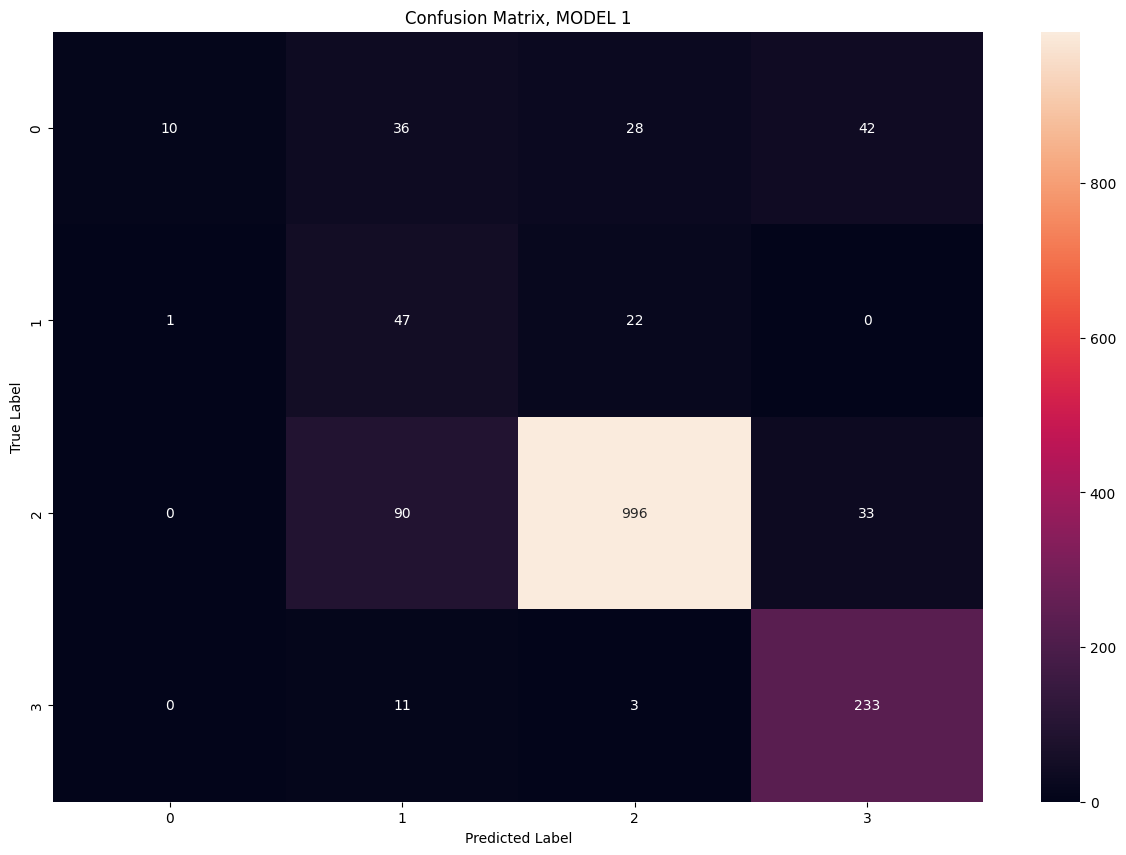

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,weights="distance")
knn.fit(xtrain,ytrain)
y_pred1 = knn.predict(xtest)
accuracy1 = accuracy_score(y_true, y_pred1)
print("Accuracy unsampled: ", accuracy1)
# Confusion Matrix for Model 1
confusion_mtx = confusion_matrix(y_true, y_pred1)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix, MODEL 1');
report1 = classification_report(y_true, y_pred1)
print("Model 1")
print(report1)

# UNSAMPLED RESULTS
# Accuracy unsampled:  0.8286082474226805
# Model 1
#               precision    recall  f1-score   support

#            0       0.91      0.09      0.16       116
#            1       0.26      0.67      0.37        70
#            2       0.95      0.89      0.92      1119
#            3       0.76      0.94      0.84       247

#     accuracy                           0.83      1552
#    macro avg       0.72      0.65      0.57      1552
# weighted avg       0.88      0.83      0.82      1552

# OVER SAMPLED KNN

Accuracy 2   0.8144329896907216
Model 4
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       116
           1       0.20      0.69      0.31        70
           2       0.98      0.85      0.91      1119
           3       0.84      0.88      0.86       247

    accuracy                           0.81      1552
   macro avg       0.64      0.71      0.64      1552
weighted avg       0.89      0.81      0.84      1552



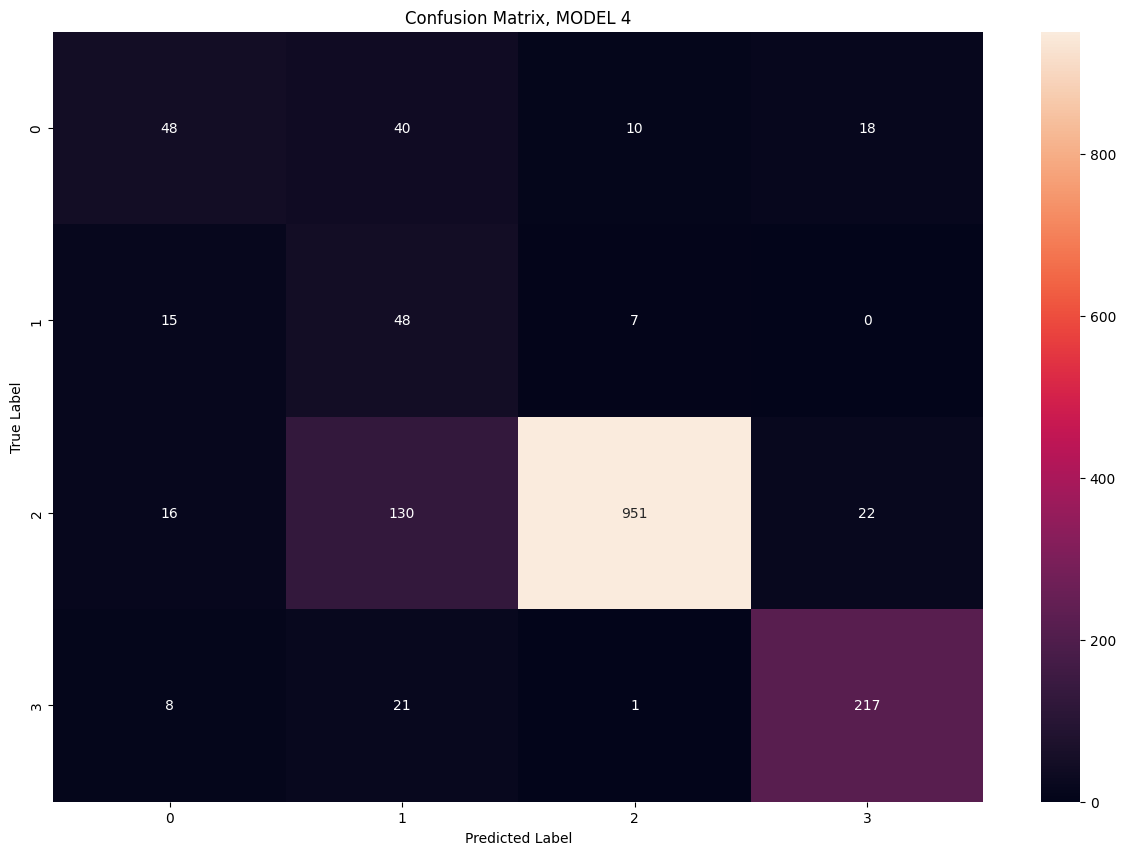

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(xtrain2,ytrain2)
y_pred2 = knn2.predict(xtest)
accuracy2 = accuracy_score(y_true, y_pred2,)
print("Accuracy 2  ", accuracy2)
# Confusion Matrix for Model 1
confusion_mtx2 = confusion_matrix(y_true, y_pred2)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx2, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix, MODEL 4');
report2 = classification_report(y_true, y_pred2)
print("Model 4")
print(report2)

# 10000 resampling SVM-SMOTE
# Accuracy 2   0.8137886597938144
# Model 1
#               precision    recall  f1-score   support

#            0       0.58      0.33      0.42       116
#            1       0.19      0.66      0.29        70
#            2       0.98      0.85      0.91      1119
#            3       0.84      0.90      0.87       247

#     accuracy                           0.81      1552
#    macro avg       0.64      0.69      0.62      1552
# weighted avg       0.89      0.81      0.84      1552

# 20000 resampling SVM-SMOTE
# Accuracy 2   0.7951030927835051
# Model 1
#               precision    recall  f1-score   support

#            0       0.61      0.29      0.40       116
#            1       0.19      0.71      0.30        70
#            2       0.98      0.83      0.90      1119
#            3       0.76      0.90      0.82       247

#     accuracy                           0.80      1552
#    macro avg       0.64      0.68      0.61      1552
# weighted avg       0.88      0.80      0.82      1552

# 30000 resampling SVM-SMOTE
# Accuracy 2   0.7893041237113402
# Model 1
#               precision    recall  f1-score   support

#            0       0.62      0.25      0.36       116
#            1       0.21      0.73      0.32        70
#            2       0.99      0.82      0.90      1119
#            3       0.69      0.92      0.79       247

#     accuracy                           0.79      1552
#    macro avg       0.63      0.68      0.59      1552
# weighted avg       0.88      0.79      0.81      1552

# NEURAL NETWORK

In [ ]:
# NORMALIZE DATASET
norm_df=(xtrain1-xtrain1.min())/(xtrain1.max()-xtrain1.min())
norm_df_test=(xtest-xtest.min())/(xtest.max()-xtest.min())
norm_df=np.asarray(norm_df)
norm_df_test=np.asarray(norm_df_test)

In [ ]:
norm_df_test.shape

(1552, 18)

In [ ]:
import keras
from keras.utils import to_categorical

y_train_NN = to_categorical(ytrain1,4)
y_trueNN = to_categorical(y_true,4)

y_train_NN = np.array(y_train_NN)
y_true_NN = np.array(y_trueNN)


x_train_NN = norm_df.reshape((norm_df.shape[0], 1, N_FEATURES))
x_test_NN = norm_df_test.reshape((norm_df_test.shape[0], 1, N_FEATURES))


In [ ]:
print('x_train shape: ', x_train_NN.shape)
print(y_train_NN.shape[0], 'training samples')
print('y_train shape: ', y_trueNN.shape)

x_train shape:  (83293, 1, 18)
83293 training samples
y_train shape:  (1552, 4)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling2D


In [ ]:
input_shape = x_test_NN[1:0].shape # (NONE,25,7)
print(input_shape)

(0, 1, 18)


In [ ]:

input_shape = x_train_NN[0,:,:].shape # (NONE,25,7)
num_classes = 4
print(input_shape)
model_NN = Sequential()

model_NN.add(keras.layers.Input(shape=(input_shape)))

model_NN.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model_NN.add(keras.layers.ReLU())
model_NN.add(keras.layers.BatchNormalization())

model_NN.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model_NN.add(keras.layers.ReLU())
model_NN.add(keras.layers.BatchNormalization())

model_NN.add(Conv1D(filters=64, kernel_size=3, padding="same"))
model_NN.add(keras.layers.ReLU())
model_NN.add(keras.layers.BatchNormalization())
model_NN.add(Flatten())
model_NN.add(Dense(num_classes, activation='softmax'))
print(model_NN.summary())


(1, 18)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             3520      
                                                                 
 re_lu (ReLU)                (None, 1, 64)             0         
                                                                 
 batch_normalization (Batch  (None, 1, 64)             256       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             12352     
                                                                 
 re_lu_1 (ReLU)              (None, 1, 64)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64)             256       
 chNormalization)                               

In [ ]:
epochs = 400
batch_size = 50


callbacks = [
	    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
]


model_NN.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_NN.fit(
    x_train_NN,
    y_train_NN,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
1333/1333 [==============================] - 7s 4ms/step - loss: 0.2079 - accuracy: 0.9302 - val_loss: 2.3474 - val_accuracy: 0.2813
Epoch 2/400
1333/1333 [==============================] - 6s 4ms/step - loss: 0.1897 - accuracy: 0.9326 - val_loss: 1.0717 - val_accuracy: 0.5209
Epoch 3/400
1333/1333 [==============================] - 5s 4ms/step - loss: 0.1861 - accuracy: 0.9340 - val_loss: 1.8780 - val_accuracy: 0.4208
Epoch 4/400
1333/1333 [==============================] - 6s 4ms/step - loss: 0.1817 - accuracy: 0.9348 - val_loss: 1.8630 - val_accuracy: 0.3171
Epoch 5/400
1333/1333 [==============================] - 5s 4ms/step - loss: 0.1798 - accuracy: 0.9354 - val_loss: 2.3626 - val_accuracy: 0.2364
Epoch 6/400
1333/1333 [==============================] - 6s 4ms/step - loss: 0.1783 - accuracy: 0.9360 - val_loss: 1.0029 - val_accuracy: 0.6077
Epoch 7/400
1333/1333 [==============================] - 5s 4ms/step - loss: 0.1762 - accuracy: 0.9361 - val_loss: 1.7635 - val_ac

In [ ]:

y_pred3 = model_NN.predict(x_test_NN)
y_pred_max = np.argmax(y_pred3, axis=1)
y_true_max = np.argmax(y_true_NN, axis=1)
print(classification_report(y_true_max, y_pred_max))

# NN MODEL
#               precision    recall  f1-score   support

#            0       0.43      0.03      0.05       116
#            1       0.09      0.26      0.13        70
#            2       0.88      0.81      0.85      1119
#            3       0.53      0.68      0.59       247

#     accuracy                           0.71      1552
#    macro avg       0.48      0.44      0.41      1552
# weighted avg       0.76      0.71      0.71      1552

49/49 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.43      0.03      0.05       116
           1       0.09      0.26      0.13        70
           2       0.88      0.81      0.85      1119
           3       0.53      0.68      0.59       247

    accuracy                           0.71      1552
   macro avg       0.48      0.44      0.41      1552
weighted avg       0.76      0.71      0.71      1552



Model 1
              precision    recall  f1-score   support

           0       0.91      0.09      0.16       116
           1       0.26      0.67      0.37        70
           2       0.95      0.89      0.92      1119
           3       0.76      0.94      0.84       247

    accuracy                           0.83      1552
   macro avg       0.72      0.65      0.57      1552
weighted avg       0.88      0.83      0.82      1552



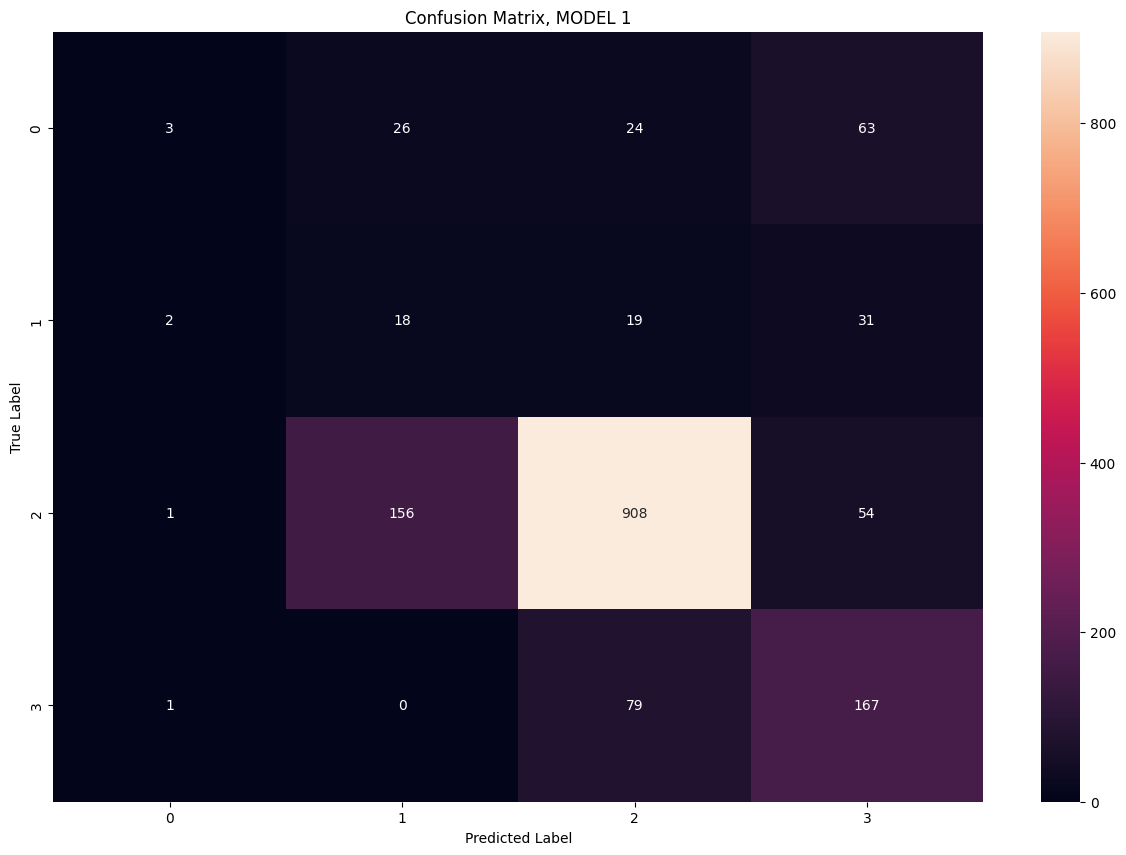

In [ ]:
confusion_mtx = confusion_matrix(y_true_max, y_pred_max)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted Label NN')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix, MODEL NN');
report1 = classification_report(y_true, y_pred1)
print("Model NN")

In [ ]:
from keras.layers import LSTM

In [ ]:
model2_NN = Sequential()
model2_NN.add(LSTM(50, input_shape=(input_shape)))
model2_NN.add(Dense(4, activation='softmax'))

model2_NN.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
model2_NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                13800     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 14004 (54.70 KB)
Trainable params: 14004 (54.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 400
batch_size = 50

history2 = model2_NN.fit(
    x_train_NN,
    y_train_NN,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
1333/1333 [==============================] - 7s 3ms/step - loss: 0.4031 - accuracy: 0.8901 - val_loss: 2.9155 - val_accuracy: 0.1315
Epoch 2/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2630 - accuracy: 0.9223 - val_loss: 2.8327 - val_accuracy: 0.1575
Epoch 3/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2448 - accuracy: 0.9248 - val_loss: 2.4676 - val_accuracy: 0.1785
Epoch 4/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2339 - accuracy: 0.9275 - val_loss: 2.4297 - val_accuracy: 0.1997
Epoch 5/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2273 - accuracy: 0.9286 - val_loss: 2.2894 - val_accuracy: 0.2202
Epoch 6/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2225 - accuracy: 0.9294 - val_loss: 2.1858 - val_accuracy: 0.2258
Epoch 7/400
1333/1333 [==============================] - 4s 3ms/step - loss: 0.2188 - accuracy: 0.9304 - val_loss: 2.1682 - val_ac

49/49 [==============================] - 0s 2ms/step
[0 1 2 3]
              precision    recall  f1-score   support

           0       0.50      0.05      0.09       116
           1       0.23      0.76      0.36        70
           2       0.99      0.75      0.86      1119
           3       0.52      0.96      0.67       247

    accuracy                           0.74      1552
   macro avg       0.56      0.63      0.50      1552
weighted avg       0.84      0.74      0.75      1552

Model LSTM


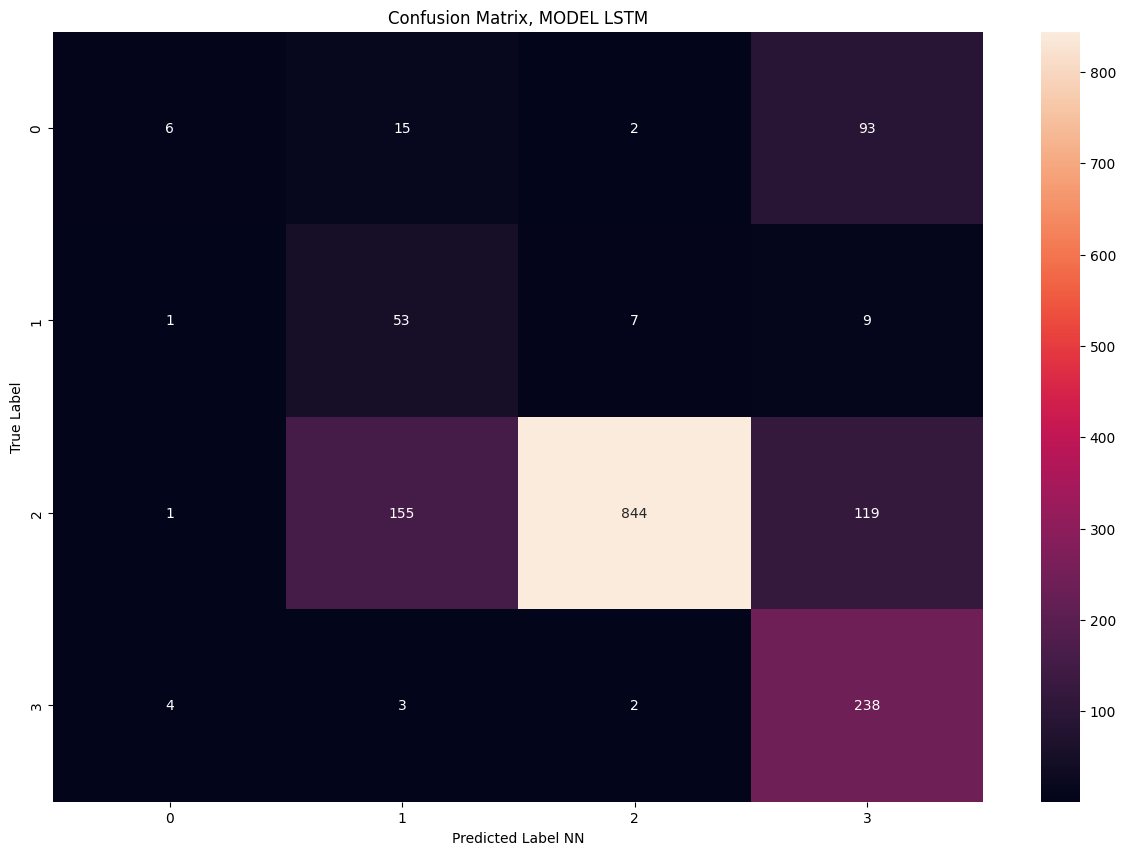

In [ ]:
y_pred4 = model2_NN.predict(x_test_NN)
y_pred_max2 = np.argmax(y_pred4, axis=1)
y_true_max = np.argmax(y_true_NN, axis=1)
print(np.unique(y_pred_max2))
print(classification_report(y_true_max, y_pred_max2))


#               precision    recall  f1-score   support

#            0       0.75      0.03      0.05       116
#            1       0.25      0.67      0.37        70
#            2       0.99      0.76      0.86      1119
#            3       0.49      0.99      0.66       247

#     accuracy                           0.74      1552
#    macro avg       0.62      0.61      0.48      1552
# weighted avg       0.86      0.74      0.75      1552
confusion_mtx = confusion_matrix(y_true_max, y_pred_max2)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted Label NN')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix, MODEL LSTM');
report1 = classification_report(y_true, y_pred1)
print("Model LSTM")